# *Scientific Progress Goes Boink!* - Training a Generative Adversarial Network on a Cartoon Dataset

by Brennan McFarland

![alt text](intro_img.png "Logo Title Text 1")

Here I apply a generative adversarial network to the task of image restoration, in the specific context of a cartoon dataset which I compiled myself with a homebrewed webscraper.  My favorite comic as a kid was *Calvin and Hobbes*, so naturally I made sure to include every strip ever published (about 10 years worth), along with some *Peanuts* and other comics, for a grand total of around 7,000 images.  Of these, I restricted my network to only work with the daily strips, as these are black and white and so lower-dimensional, making training easier.  As we'll see, when adequately tuned the GAN returns what I think are some pretty good results, and although I'm submitting this as an assignment, as a personal project I still consider it far from finished and plan on continuing to work on it to see what else it can do.  So, without further ado, let's transmogify some noise.

### Imports - The Boring Part

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from keras.layers import Lambda
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
import argparse
import os
import math

import sys
import csv
import re
import random
from skimage.transform import downscale_local_mean
from skimage import io
import numpy as np
from keras import backend as K
from keras.engine.topology import Layer
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Multiply, Input, Conv2D, Conv3D, Conv2DTranspose, Conv3DTranspose, MaxPooling2D, MaxPooling3D, UpSampling2D, Dense, Flatten, Activation, Reshape, BatchNormalization, LeakyReLU, PReLU
from keras.optimizers import RMSprop, Adam
from keras.callbacks import LambdaCallback
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras import initializers

Using TensorFlow backend.


### Loading the Data

I put the file location of the data and where the output should go (if it gets saved, which for this notebook never happens) in variables to make it easier to run the network on different systems.  I mostly tested it on my desktop PC, which has an enthusiast (GTX 660 6GB) graphics card and was able to train each version of the GAN in only a few minutes.  Running the network locally on a different system should be as easy as changing these strings to point to the location of the data.

In [2]:
data_root = 'E:/cartoon-gan/data'
output_root = 'E:/cartoon-gan'
random.seed()

My webscraper stored metadata for each image in a csv file, most of which the network ignores, but it's still necessary for loading the images themselves.

In [3]:
def load_metadata():
    metadata = []
    with open(data_root + 'metadata.csv', 'r', newline='') as metadata_file:
        reader = csv.reader(metadata_file, quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in reader:
            metadatum = row[:2] + [int(n) for n in re.findall(r'\d+', row[2])]
            metadata.append(metadatum)
    return metadata

In [4]:
metadata = load_metadata()
random.shuffle(metadata)
metadata_train = metadata[len(metadata)//10:]
metadata_test = metadata[:len(metadata_train)]
num_data = len(metadata)

classes = set([datum[0] for datum in metadata])
# build a dictionary mapping between name strings and ids
class_to_id = dict((n, i) for i, n in enumerate(classes))
id_to_class = dict((i, n) for i, n in enumerate(classes))
num_classes = len(classes)

The DataProvider class is responsible for feeding training and/or testing data into the network.  It inherits from Keras' Sequence class because in theory that should make it load data in parallel to training, but for this implementation it doesn't do that because I'm using a custom training loop (more on that later).  Still, it nicely encapsulates the data loading and preprocessing step.  The primary function is get_batch, called every time the network requests data.  It first loads an image from disk and attempts to scale it to the target dimensions, 150x450 pixels, by either truncating or padding it with white.  If the proportion of the image dimensions is too far outside this range, for example if it is a much larger Sunday strip, the image is rejected and another is loaded instead.  The result is that the network will always receive images of the same dimensions.  It scales the grayscale values to the range of 0 (black) to 1 (white) and reshapes the resulting array so that tensorflow can process it.  This is the target for the network.  The pattern is simply the target image run through the convert_to_sample function, which removes (sets to white) 80% of the pixels at random.

In [5]:
class DataProvider(Sequence):

    metadata = None
    batch_size = 1 # because I get OOM otherwise
    
    def __init__(self, metadata):
        self.metadata = metadata
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        x, y = self.get_batch(self.batch_size, self.metadata)
        if x is None or y is None:
            raise ValueError("input x or y is none")
        return x, y

    # note to self for the future: optimize the batches to use np arrays from the getgo?
    def get_batch(self, batch_size, metadata):
        img_x, img_y = 150, 450
        batch_x = np.zeros((batch_size, img_x, img_y), dtype=float)
        batch_y = np.zeros((batch_size, img_x, img_y), dtype=float)
        for i in range(batch_size):
            img_scaled = None
            datum_index = random.randint(0, len(metadata)-1)
            j = 0
            while img_scaled is None:
                img_scaled = self.get_image(metadata, (datum_index + j) % len(metadata))
                metadatum = metadata[(datum_index + j) % len(metadata)]
                latent_category = class_to_id[metadatum[0]]
                j += 1
            
            # put it in a tensor after downscaling it and padding it
            img_downscaled = downscale_local_mean(img_scaled, (2, 2))
            # normalize channel values
            batch_y[i] = np.pad(img_downscaled, ((0,0), (0, img_y-img_downscaled.shape[1])), 'maximum')
            batch_y[i] /= 255.0
            batch_x = self.convert_to_sample(batch_y)
        return np.expand_dims(batch_x, axis=3), np.expand_dims(batch_y, axis=3)

    # if outside the tolerance range, return None (it's not a valid datum)
    # if to large, crop from both sides to fit
    # if to small, pad with maximum value (white) to fit
    def scale_to_target(self, image, initial_y, target_y, shrink_tolerance, grow_tolerance):
        if(target_y-initial_y > grow_tolerance or initial_y-target_y > shrink_tolerance):
            return None
        elif(initial_y > target_y):
            return image[:target_y]
        else: # initial_y <= target_y
            padding = (target_y-initial_y)//2
            return np.pad(image, ((padding, target_y - initial_y - padding),(0,0)), 'maximum')

    def get_image(self, metadata, datum_index):
        img_x, img_y = 150, 450
        metadatum = metadata[datum_index]
        img_raw = io.imread(data_root + 'images/' + metadatum[0] + metadatum[1] + '.png', as_gray=True)
        img_scaled = self.scale_to_target(img_raw, metadatum[2], img_x*2, 5, 120)
        return img_scaled


    # 1 is white, 0 is black, remember
    def convert_to_sample(self, img):
        p_black = .2
        sample = np.random.choice((0.0, 1.0), size=img.shape, p=(p_black, 1.0-p_black)) # p is probability of each option
        # element-wise max
        return np.maximum(sample, img)

### PixelCNN

Most examples of generative networks I found online used transposed convolution.  However, I also found a few that used a technique called PixelCNN, so I decided to try both and compare them.  The idea is that it still does convolution, but instead of including input from all neighboring pixels, pixels "later" (ie, to the right of the current pixel in the same row and all subsequent rows) in the image are masked.  Keras doesn't have an implementation of PixelCNN layers, so I built one myself.  In the build method, I define the standard convolution and bias weights and also a mask, where 1s are unmasked kernel dimensions and 0s are masked.  In the call method, which performs the logical operations of the layer, I set all the masked values to 1 (white) so the actual value of the convoluted image has no effect at that point.

In [6]:
class PixelCNN(Conv2D):

    def __init__(self, filters, *args, mask_current=True, n_channels=1, mono=False, **kwargs):
        self.mask_current = mask_current
        self.mask = None
        self.num_filters = filters
        self.num_channels = n_channels
        super(PixelCNN, self).__init__(filters, *args, **kwargs)


    # this is where you will define your weights
    def build(self, input_shape):
        # (filter width, filter height, input dimensions/channels/filters, output filters)
        kernel_shape = self.kernel_size + (input_shape[-1], self.num_filters)
        # the initializer here is NOT what keras normally uses, keras uses golorot uniform, but that just resulted in
        # initially black images and made it harder for the network to start learning.  using this distribution instead
        # results in noisy initial outputs that convey information for the network to learn off of
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=initializers.RandomUniform(minval=-5, maxval=5), 
                                      trainable=True)
        
        # normally, keras initializes the biases to 0, but the random uniform works better here.  If the initializers are
        # not carefully tuned, the initial images will tend to be all black or white and start the network with little
        # infoormation to learn on
        self.bias = self.add_weight(name='bias',
                                shape=kernel_shape,
                                initializer=initializers.RandomUniform(minval=-50, maxval=40),
                                trainable=True)
        self.mask = np.zeros(self.kernel.shape)
        assert self.mask.shape[0] == self.mask.shape[1] # assert that mask height = width
        filter_size = self.mask.shape[0]
        filter_center = filter_size/2

        # unmask everything before the center
        self.mask[:math.floor(filter_center)] = 1 # unmask rows above
        self.mask[:math.ceil(filter_center), :math.floor(filter_center)] = 1 # unmask cols to the left in same row

        if not self.mask_current:
            self.mask[math.ceil(filter_center), math.ceil(filter_center)] = 1

        self.mask = K.variable(self.mask)

        self.built = True

    # this is where the layer's logic lives. Unless you want your layer to
    # support masking, you only have to care about the first argument
    # passed to call: the input tensor
    def call(self, x, mask=None):
        ''' calculate gated activation maps given input maps '''
        # a note to myself for the future: I can probably precalculate the mask transformation in build instead to optimize
        output = K.conv2d(x, self.kernel * self.mask + (-self.mask + 1) + self.bias,
                          strides=self.strides,
                          padding=self.padding,
                          data_format=self.data_format)
        output = self.activation(output)
        return output

    def get_config(self):
        return dict(list(super().get_config().items()) + list({'mask': self.mask_current}.items()))
    
    # in case your layer modifies the shape of its input, you should
    # specify here the shape transformation logic. This allows Keras to
    # do automatic shape inference
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + tuple([self.num_filters])


### The GAN Itself

I encapsulated the GAN itself as its own class into which I could easily inject the generator and disciminator, making it easier to run multiple versions without as much broilerplate.  I also created this progress reporting function.  It loads an image from a provided test dataset and displays the noisy-masked input, the GAN's output, and the ground truth image.  It's important to note that although the network does report loss, its not really that useful as an intuitive metric because instead of decreasing smoothly as it trains it bounces back and forth as the generator and discriminator compete against each other.  This makes it hard to evaluate the performance of the network, so I turned off loss reporting an just have it display an image each training epoch to qualitatively judge how well it does.

In [7]:
def report_epoch_progress(epoch, logs, gen_model, data_test):
    print('epoch', epoch, 'progress report:')
    example = data_test.__getitem__(3)
    latent = example[0]
    img = gen_model.predict(latent)
    img = np.squeeze(img, axis=(0,3))
    img *= 255.0
    img = img.astype(int)

    actual = example[1]
    actual = np.squeeze(actual, axis=(0,3))
    actual *= 255.0
    actual = actual.astype(int)

    latent = np.squeeze(latent, axis=(0,3))
    latent *= 255.0
    latent = latent.astype(int)

    print("INPUT")
    io.imshow(latent, cmap='gray')
    io.show()
    print("OUTPUT")
    io.imshow(img, cmap='gray')
    io.show()
    print("TARGET")
    io.imshow(actual, cmap='gray')
    io.show()

And here we have the GAN architecture itself.  It takes as input a generator and discriminator model, and from that creates an adversarial model by linking them in sequence.  In compile I prepare the networks for training, including setting the learning rates.  I set the learning rate for the discriminator much lower, because at higher values, it would quickly outpace  the generator in telling real images apart from fakes, its loss would drop to zero, and the generator would have a hard time finding the gradient to improve.  I also have callbacks for saving the model and writing to tensorboard logs, though right now only the progress callback I wrote myself is functional because of the custom training loop.  Speaking of which, this loop is implemented in the train method.  At each step, it grabs an image/noise-masked image pair to train on.  Given the noise-masked image, the generator tries to produce an image that will fool the generator, and the discriminator trains on both the real and fake image to get better at telling them apart.  Then, the weights in the discriminator part of the network are frozen, disabling training on that part of the network, and the whole model is trained to try to fool the discriminator.  This is the same in effect as training just the generator, except we still run the output of the generator through the discriminator to see how good the former is at producing fakes.  There's also the option to print loss, but as I mentioned before this doesn't really tell us much, so I never use it here.  Now we can just give it a couple network architectures for the generator and discriminator, and we're all set!

In [8]:
class GANModel():
    
    def __init__(self, g, d):
        self.generator = g
        self.discriminator = d
        
        gan_inputs = Input(shape=(150, 450, 1))
        gan_images = self.generator(gan_inputs)
        gan_output = self.discriminator(gan_images)

        self.gan = Model(inputs=gan_inputs, outputs=[gan_images, gan_output])

    def compile(self):
        g_optimizer = Adam(lr=.0001)
        d_optimizer = Adam(lr=.00001) # lower lr necessary to keep discriminator from getting too much better than generator
        gan_optimizer = Adam(lr=.0001)

        self.discriminator.trainable = True
        self.discriminator.compile(optimizer=d_optimizer, loss='mse')
        self.discriminator.trainable = False
        loss = ['binary_crossentropy', 'mse']
        loss_weights = [100, 1]
        self.gan.compile(optimizer=gan_optimizer, loss=loss, loss_weights=loss_weights)
        self.discriminator.trainable = True
        
        # only the progress callback gets used right now, as I'm not sure how to make this work with a custom training loop
        progress_callback = LambdaCallback(on_epoch_end=report_epoch_progress)
        checkpoint_callback = ModelCheckpoint('./model-checkpoint.ckpt')
        tensorboard_callback = TensorBoard(log_dir='../logs/tensorboard-logs', write_images=True)
        self.callbacks = [progress_callback]
        self.gan.summary()

    def train(self, epochs, data_train, data_test, verbose=False):
        self.data_train = data_train
        self.data_test = data_test
        steps_per_epoch = num_data//self.data_train.batch_size
        discriminator_updates = 1 # discriminator updates per generator update
        report_epoch_progress(None, None, self.generator, self.data_test)
        
        # manually set callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.set_model(self.gan)

        # custom training loop
        for epoch in range(epochs):
            for step in range(steps_per_epoch):
                current_batch = self.data_train.__getitem__(0)
                # generate "fake" images
                generator_inputs = current_batch[0]
                generated_images = self.generator.predict(generator_inputs, batch_size=1)
                # train discriminator on "real" images from the dataset and "fake" ones that were generated
                true_inputs, true_labels = current_batch[1], np.ones(len(current_batch[1]))
                fake_inputs, fake_labels = generated_images, np.zeros(len(generated_images))
                for _ in range(discriminator_updates):
                    d_loss_real = self.discriminator.train_on_batch(true_inputs, true_labels)
                    d_loss_fake = self.discriminator.train_on_batch(fake_inputs, fake_labels)
                    d_loss = .5 * np.sum((d_loss_real, d_loss_fake))
                # halt training on the discriminator
                self.discriminator.trainable = False
                # train generator to try to fool the discriminator
                g_loss = self.gan.train_on_batch(generator_inputs, [true_inputs, true_labels])
                # and allow training on the discriminator to continue
                self.discriminator.trainable = True
                if verbose == True:
                    print('step ', step, '/', steps_per_epoch, 'd_loss: ', d_loss, 'g_loss: ', g_loss)
            # manually call callbacks since we're doing a custom fit
            logs = {'loss': g_loss}
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs, self.generator, self.data_test)
        # manually terminate callbacks since we're doing a custom fit
        for callback in self.callbacks:
            callback.on_train_end('_')


Also, a sidenote: because we can't measure the network's performance empirically, we can't really use a validation set.  Even the test set is only for our visual confirmation that the network is working; it doesn't actually produce any useful measurements that we can use to quantitatively evalutate it.

### Experiment 1: Transposed Convolution vs PixelCNN

Let's test the difference between the PixelCNN and transposed convolution.  We start by defining the discriminator architecture, which remains constant throughout since it already works well enough; the tricky part is the generator.  It's just a series of convolutions and leaky ReLU activation functions, with batch normalization to make sure our numbers always stay reasonably scaled (making it easier to compute):

In [9]:
d_input = Input(shape=(150, 450, 1))
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(d_input)
layer = BatchNormalization()(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Conv2D(filters=32, kernel_size=(4, 4), strides=4, padding='same')(layer)
layer = LeakyReLU(.25)(layer)
layer = Flatten()(layer)
layer = Dense(128)(layer)
layer = Activation('sigmoid')(layer)
d_output = Dense(1)(layer)

For our initial generator architecture, we'll start with a couple layers of PixelCNN followed by some transposed convolution, with parameterized ReLU as the activation functions after each layer.  The last convolution is followed by a sigmoid activation function, which ensures our output values are always scaled to 1:

In [10]:
g_input = Input(shape=(150, 450, 1))
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(g_input)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

I created a helper function that takes in inputs and outputs for both networks and test runs the GAN for 3 iterations, so we can get an idea of how well each architecture performs.

In [11]:
def test_gan(g_input, g_output, d_input, d_output, epochs=3):
    # we have to reinstantiate the generator and discriminator or the weights won't be reset
    generator = Model(g_input, g_output, name='generator')
    discriminator = Model(d_input, d_output, name='discriminator')
    gan_model = GANModel(generator, discriminator)
    gan_model.compile()
    data_train = DataProvider(metadata_train)
    data_test = DataProvider(metadata_test)
    gan_model.train(epochs, data_train, data_test)

Let's use it to train our initial network architecture:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       2716977   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,717,041
Trainable params: 2,716,929
Non-trainable params: 112
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


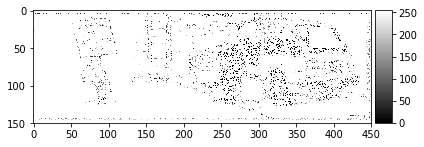

OUTPUT


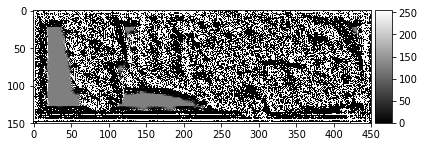

TARGET


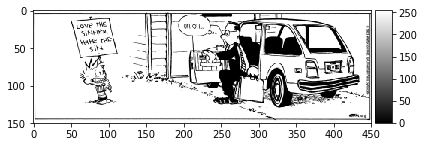

epoch 0 progress report:
INPUT


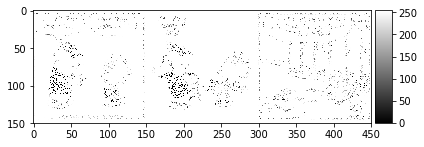

OUTPUT


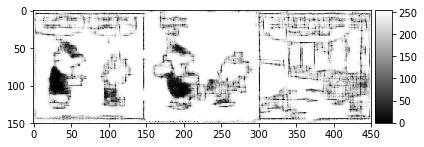

TARGET


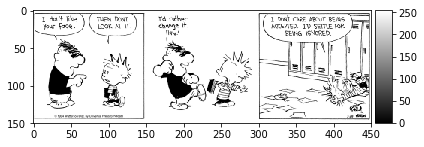

epoch 1 progress report:
INPUT


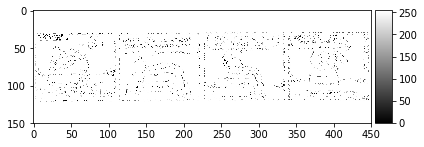

OUTPUT


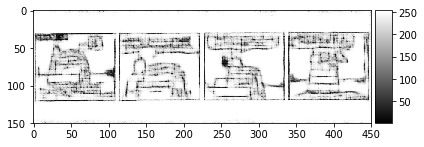

TARGET


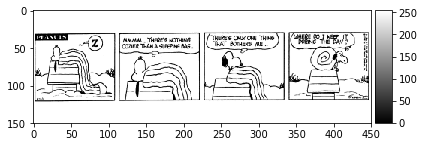

epoch 2 progress report:
INPUT


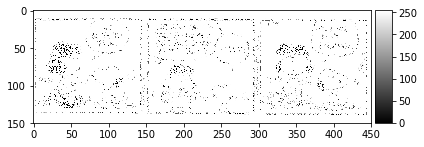

OUTPUT


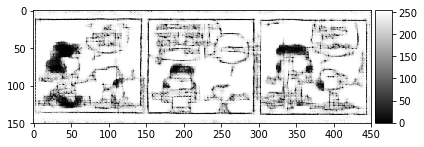

TARGET


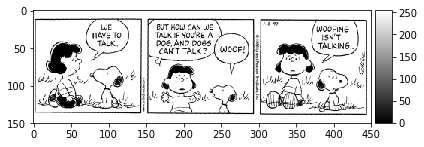

In [12]:
test_gan(g_input, g_output, d_input, d_output)

We can already see that even on the first attempt, the GAN is able to construct reasonable reconstructions with a decent level of fidelity.  Next we try a generator composed entirely of transposed convolution layers but otherwise the same:

In [13]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       2713529   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,713,593
Trainable params: 2,713,449
Non-trainable params: 144
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


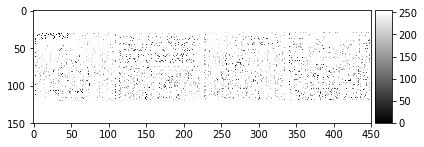

OUTPUT


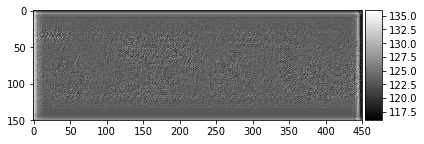

TARGET


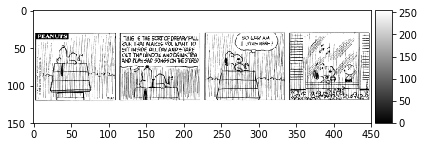

epoch 0 progress report:
INPUT


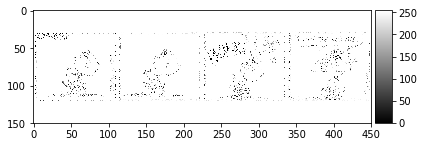

OUTPUT


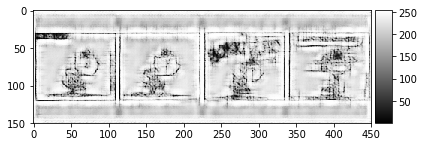

TARGET


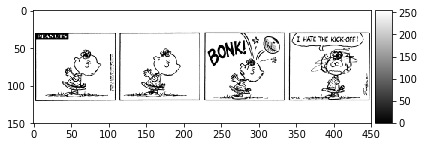

epoch 1 progress report:
INPUT


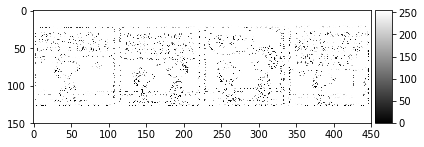

OUTPUT


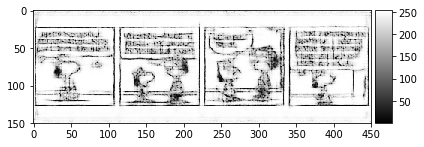

TARGET


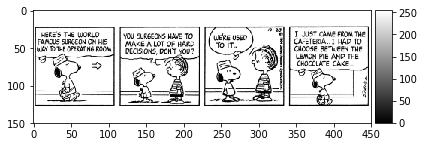

epoch 2 progress report:
INPUT


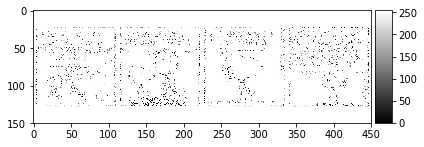

OUTPUT


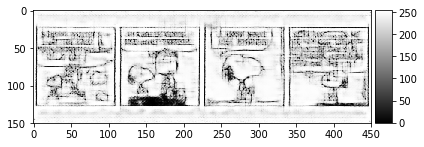

TARGET


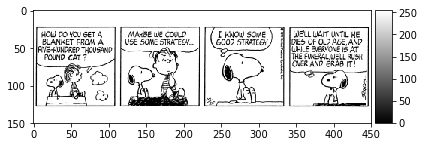

In [14]:
test_gan(g_input, g_output, d_input, d_output)

And testing it we can see subtle but arguably better improvement upon training.  The reconstructed image is still a little fuzzy and it struggles to fill completely dark spaces, but we see less of a crosshatch pattern of vertical and horizontal lines than before.  Overall, the network seems better able to capture the line structure of the cartoons than before.  Next, we'll test it with a generator composed solely of PixelCNN layers:

In [15]:
g_input = Input(shape=(150, 450, 1))
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(g_input)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(8, 7, strides=1, mask_current=True, padding='same')(layer)
layer = PReLU()(layer)
layer = PixelCNN(1, 7, strides=1, mask_current=True, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       2726656   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 2,726,720
Trainable params: 2,726,656
Non-trainable params: 64
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


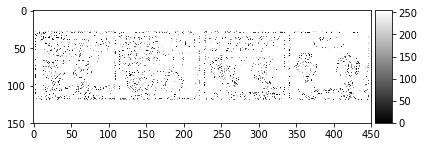

OUTPUT


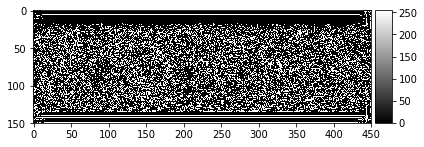

TARGET


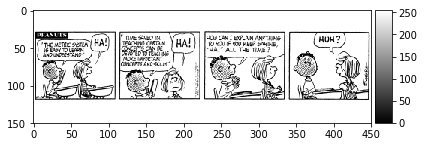

epoch 0 progress report:
INPUT


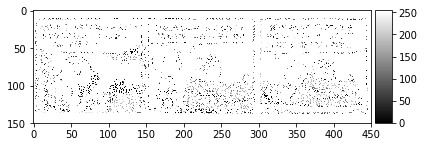

OUTPUT


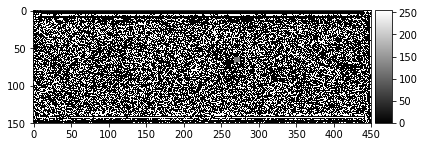

TARGET


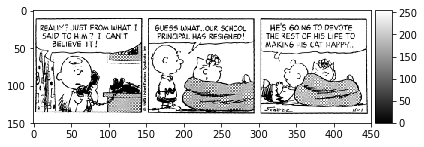

epoch 1 progress report:
INPUT


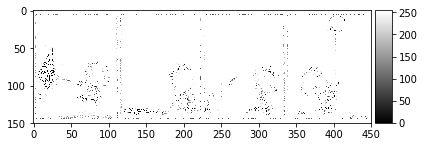

OUTPUT


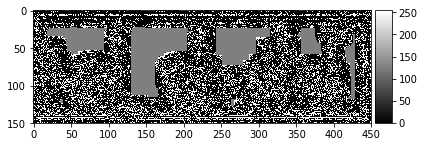

TARGET


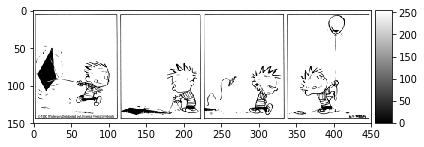

epoch 2 progress report:
INPUT


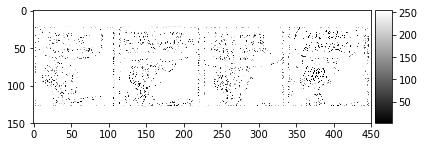

OUTPUT


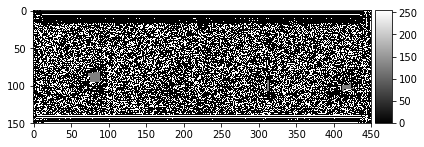

TARGET


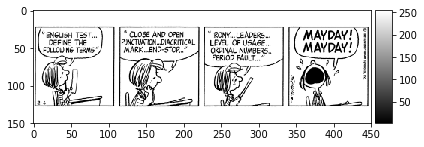

In [16]:
test_gan(g_input, g_output, d_input, d_output)

And the results are terrible!  It appears the network is completely incapable of capturing any of the image structure, and is stuck on random noise even after training.  Maybe the hyperparameters or details of my implementation lended themselves poorly to this training scenario, or maybe the layer works better in other contexts.  On my dataset though, I got the best results using only transposed convolution rather than PixelCNN or a mix of both.  Transposed convolution wins!

### More Layers

Now that we have a reasonably good idea of a good network architecture, let's try to improve it by adding more layers.  Instead of 6 convolutional layers, let's try 12:

In [17]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 7, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
for _ in range(10):
    layer = Conv2DTranspose(8, 7, strides=1, padding='same')(layer)
    layer = BatchNormalization(momentum=.9)(layer)
    layer = PReLU()(layer)
layer = Conv2DTranspose(1, 7, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       5972585   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 5,972,649
Trainable params: 5,972,409
Non-trainable params: 240
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


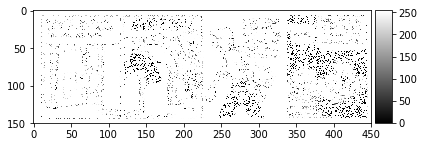

OUTPUT


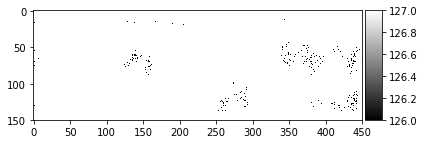

TARGET


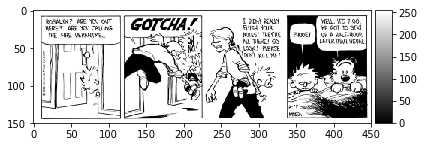

epoch 0 progress report:
INPUT


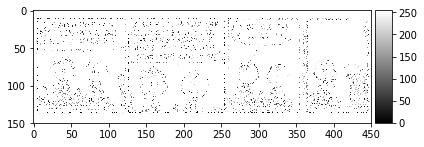

OUTPUT


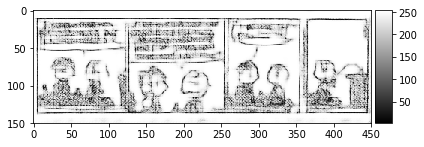

TARGET


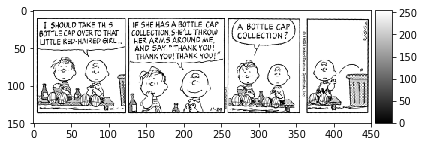

epoch 1 progress report:
INPUT


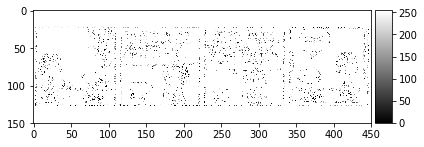

OUTPUT


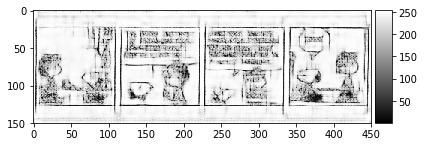

TARGET


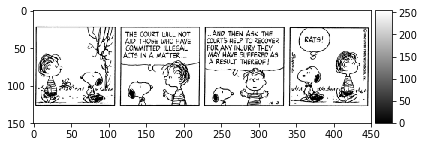

epoch 2 progress report:
INPUT


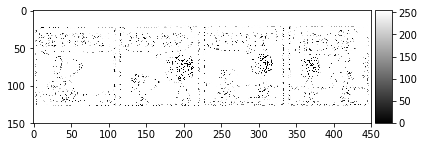

OUTPUT


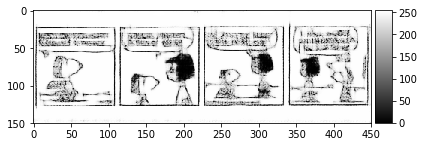

TARGET


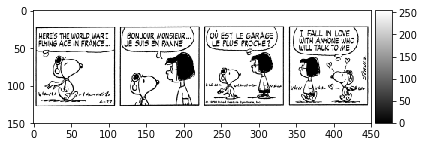

In [18]:
test_gan(g_input, g_output, d_input, d_output)

And testing it, we see even more improvement.  In particular, there's no more blurry gray smudging; the image is almost entirely black lines or white background.  Lines tend to be better defined, and entirely black areas of the image are depicted (for the most part) as such.  We even see an approximation of text in the speech bubbles, though of course I wouldn't expect to see anything resembling real letters, let alone real words.  The point, though, is that this looks much more like a bad photocopy of the original image and is much closer to the ground truth.

### Smaller Kernels

Lastly, let's see what happens if we use smaller kernels.  All the previous architectures used 7x7 kernels, but here we can try 4x4:

In [19]:
g_input = Input(shape=(150, 450, 1))
layer = Conv2DTranspose(8, 4, strides=1, padding='same')(g_input)
layer = BatchNormalization(momentum=.9)(layer)
layer = PReLU()(layer)
for _ in range(10):
    layer = Conv2DTranspose(8, 4, strides=1, padding='same')(layer)
    layer = BatchNormalization(momentum=.9)(layer)
    layer = PReLU()(layer)
layer = Conv2DTranspose(1, 4, strides=1, padding='same')(layer)
g_output = Activation('sigmoid')(layer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 150, 450, 1)       0         
_________________________________________________________________
generator (Model)            (None, 150, 450, 1)       5950937   
_________________________________________________________________
discriminator (Model)        (None, 1)                 132065    
Total params: 5,951,001
Trainable params: 5,950,761
Non-trainable params: 240
_________________________________________________________________
epoch None progress report:


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


INPUT


c:\users\his eminence\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


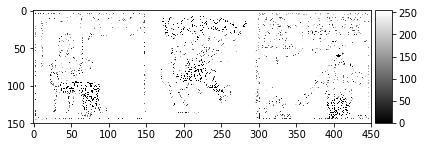

OUTPUT


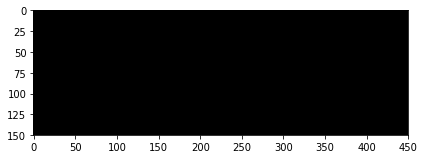

TARGET


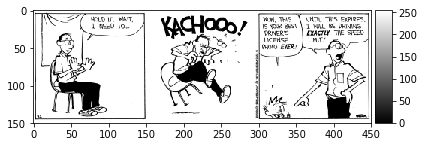

epoch 0 progress report:
INPUT


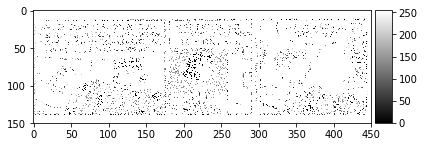

OUTPUT


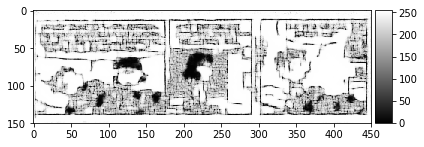

TARGET


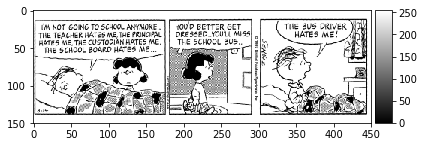

epoch 1 progress report:
INPUT


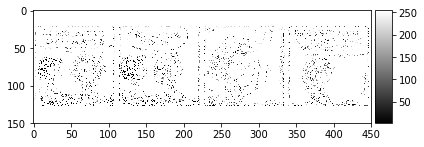

OUTPUT


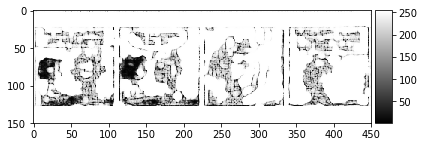

TARGET


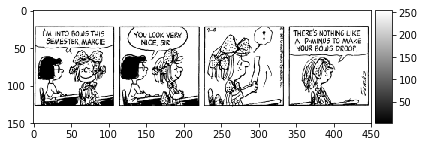

epoch 2 progress report:
INPUT


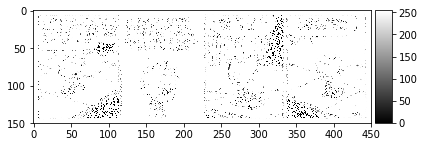

OUTPUT


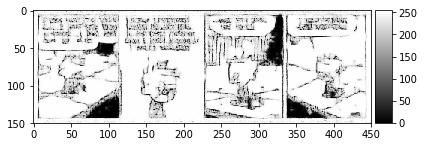

TARGET


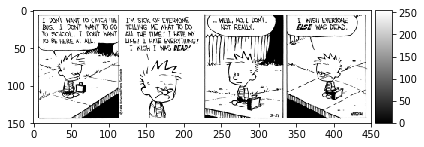

In [20]:
test_gan(g_input, g_output, d_input, d_output)

It's difficult to say whether the result is better or worse per-se, but we can make a few more specific observations.  The clarity of lines is less and the network seems to struggle more to capture the essence of objects, but it seems to do better with smaller details.  This could be because while smaller kernels means the convolution over each pixel is "aware" of less of its neighbors, its more "focused" on those immediately around it, enabling it to capture finer details with less understanding of the whole structure.  Ultimately, I think this is the best architecture so far, though I could probably keep tweaking it a lot in the future to get better results.

### Future Work

There's a lot of things I wanted to try with this GAN but didn't end up having the time to do, at least some of which I'm planning on doing at a later date.  Some of the major ones are:
* generation given only a category, using one-hot vectors, mixture models or learned embeddings as input, possibly as a transformation of pure noise
* fanning the magnitude kernel sizes/strides in and/or out based on their depth in the network, to try and capture both finer details and broader structure
* better balancing the learning of the discriminator and learner
* optimizing it to run faster/more in parallel, particularly with the data loader
Overall, I was surprised how well the network reconstructed details that a human might only see as random noise, and I was surprised at its level of understanding of objects and line strokes.  In the future, I plan to make it work even better!

This code can also be found on GitHub at https://github.com/brennanmcfarland/cartoon-gan
I also have a shareable link to this notebook in my drive folder: https://colab.research.google.com/drive/1Cbujbt0k8MDK3kmHY9qVDApKffQLYN0T[link text](https://)